In [7]:
%%html
<style>
.slider-width {
    width: 400px;
}
</style>

In [77]:
# Import necessary libraries
import tkinter as tk
import tkinter.filedialog as fd
import ipywidgets as widgets
import os
import access2thematrix
import sys
import numpy as np
import matplotlib.pyplot as plt
import pyransac3d as pyrsc
import pandas as pd
from scipy.linalg import lstsq
from functools import partial
import ipyvuetify as v
from traitlets import observe
import re

# Initialize the access2thematrix module
mtrx_data = access2thematrix.MtrxData()

# Create a Tkinter root window and hide it
root = tk.Tk()
root.withdraw()
root.call('wm', 'attributes', '.', '-topmost', True)

# Define a function to calculate the equation of a plane
def plane_eq(X, Y, coeffs):
    return coeffs[0] * X + coeffs[1] * Y + coeffs[2]

# Open a file dialog to select the .Z_mtrx file to analyze
infile = fd.askopenfilename(parent=root, title='Select .Z_mtrx file to analyze')
# Get the relative path of the selected file
infile = os.path.relpath(infile, os.getcwd())
# Extract the filename without the extension and 'default_'
filename = os.path.basename(infile).replace('.Z_mtrx', '').replace('default_', '')

# Print 'Sample name:' and display a text input widget to enter the sample name
print('Sample name:')
sample = widgets.Text(description='Sample name', style={'description_width': 'initial'}, value='Ta2Se8I')
display(sample)


Sample name:


Text(value='Ta2Se8I', description='Sample name', style=DescriptionStyle(description_width='initial'))

[-3.125      -3.06547619 -3.00595238 -2.94642857 -2.88690476 -2.82738095
 -2.76785714 -2.70833333 -2.64880952 -2.58928571 -2.5297619  -2.4702381
 -2.41071429 -2.35119048 -2.29166667 -2.23214286 -2.17261905 -2.11309524
 -2.05357143 -1.99404762 -1.93452381 -1.875      -1.81547619 -1.75595238
 -1.69642857 -1.63690476 -1.57738095 -1.51785714 -1.45833333 -1.39880952
 -1.33928571 -1.2797619  -1.2202381  -1.16071429 -1.10119048 -1.04166667
 -0.98214286 -0.92261905 -0.86309524 -0.80357143 -0.74404762 -0.68452381
 -0.625      -0.56547619 -0.50595238 -0.44642857 -0.38690476 -0.32738095
 -0.26785714 -0.20833333 -0.14880952 -0.08928571 -0.0297619   0.0297619
  0.08928571  0.14880952  0.20833333  0.26785714  0.32738095  0.38690476
  0.44642857  0.50595238  0.56547619  0.625       0.68452381  0.74404762
  0.80357143  0.86309524  0.92261905  0.98214286  1.04166667  1.10119048
  1.16071429  1.2202381   1.2797619   1.33928571  1.39880952  1.45833333
  1.51785714  1.57738095  1.63690476  1.69642857  1.7

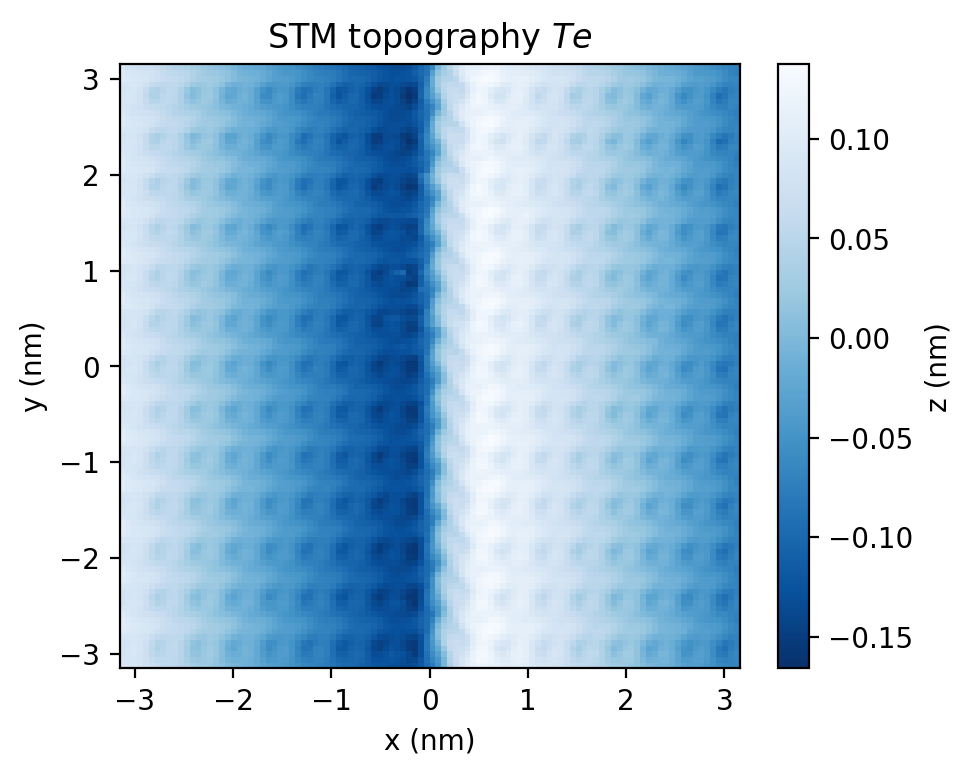

In [79]:
sample_name = re.sub(r"(\d+)", r"_\1", sample.value)
sample_name = f'${sample_name}$'

traces, _ = mtrx_data.open(infile)
selected_image, _ = mtrx_data.select_image(traces[0])

# change data format for background fitting
x = np.linspace(-selected_image.width * 0.5e9, selected_image.width * 0.5e9, selected_image.data.shape[1])
y = np.linspace(-selected_image.height * 0.5e9, selected_image.height * 0.5e9, selected_image.data.shape[0])
xx, yy = np.meshgrid(x, y)
z = selected_image.data.flatten() * 1e9
xyz = np.column_stack((xx.flatten(), yy.flatten(), z))


# do fit https://math.stackexchange.com/questions/99299/best-fitting-plane-given-a-set-of-points
tmp_A = np.array([xyz[:,0], xyz[:, 1], np.full(xyz.shape[0], 1)]).transpose()
tmp_b = [xyz[:, 2]]
b = np.matrix(tmp_b).T
A = np.matrix(tmp_A)
fit, residual, rnk, s = lstsq(A, b)

# Remove background
data_no_bg = selected_image.data * 1e9 - plane_eq(xx, yy, fit)

# Plot and save the data without background
plt.figure(figsize=(5,4), dpi=200)
plt.xlabel('x (nm)')
plt.ylabel('y (nm)')
plt.title('STM topography ' + sample_name)
plt.pcolormesh(x, y, data_no_bg, cmap='Blues_r')
c = plt.colorbar()
c.set_label('z (nm)')

# Save the plot in EPS format
if not os.path.exists('z-topo-fft'):
    os.makedirs('z-topo-fft')
plt.savefig(f'z-topo-fft/z-no_bg_{filename}.eps', facecolor='w', format='eps', dpi=600)
header = f'File format = ASCII\nx-pixels = {selected_image.data.shape[1]}\ny-pixels = {selected_image.data.shape[0]}\nx-length = {selected_image.width*1e9}\ny-length = {selected_image.height*1e9}\nz-unit = nm\nStart of data:'
np.savetxt(f'z-topo-fft/z-no_bg_{filename}.asc', data_no_bg, delimiter='\t', header=header, fmt='%.6f')

In [8]:
import ipyvuetify as v
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import Output, HBox, VBox, Layout
from traitlets import observe
from IPython.display import display
import scipy.fftpack as sfft

# Apply 2D-FFT to data 
data_fft = sfft.fft2(data_no_bg)
data_shift = sfft.fftshift(data_fft)
x_fft = sfft.fftshift(np.fft.fftfreq(selected_image.data.shape[1], d=x[1]-x[0]))
y_fft = sfft.fftshift(np.fft.fftfreq(selected_image.data.shape[0], d=y[1]-y[0]))

# Set the initial colormap range
min_value = np.abs(data_fft).min()
max_value = np.abs(data_fft).max()

# Create a range slider
range_slider = v.RangeSlider(v_model=[min_value, max_value], min=np.abs(data_fft).min(), max=np.abs(data_fft).max(), step=0.01, class_='slider-width')

# Create text fields for min and max values
min_text_field = v.TextField(label="Min", v_model=str(min_value))
max_text_field = v.TextField(label="Max", v_model=str(max_value))

# Create a figure and axes
fig, ax = plt.subplots(figsize=(3,3), dpi=100)

# Create an image plot
img_plot = plt.pcolormesh(x_fft, y_fft, np.abs(data_shift), cmap='bone_r', vmin=min_value, vmax=max_value)
c = plt.colorbar(img_plot, fraction=0.046, pad=0.04)
plt.title('FFT topography')
plt.xlabel('$k_x\ (nm^{-1})$')
plt.ylabel('$k_y\ (nm^{-1})$')

output = Output()

@observe('v_model')
def update_colormap_range(change):
    # Update the min and max values
    min_value, max_value = change.new
    min_text_field.v_model = str(min_value)
    max_text_field.v_model = str(max_value)
    # Update the colormap range
    img_plot.set_clim(vmin=min_value, vmax=max_value)
    # Redraw the plot
    with output:
        output.clear_output(wait=True)
        display(fig)

def update_range_slider(widget, event, data):
    # Update the range slider values
    range_slider.v_model = [float(min_text_field.v_model), float(max_text_field.v_model)]

range_slider.observe(update_colormap_range, 'v_model')
min_text_field.on_event('change', update_range_slider)
max_text_field.on_event('change', update_range_slider)

# Arrange the components in a layout
controls_box = VBox([min_text_field, max_text_field, range_slider])
layout = HBox([controls_box, output])

# Set the layout style
controls_box.layout = Layout(margin='20px')
output.layout = Layout(margin='20px')

display(layout)

plt.close(fig)


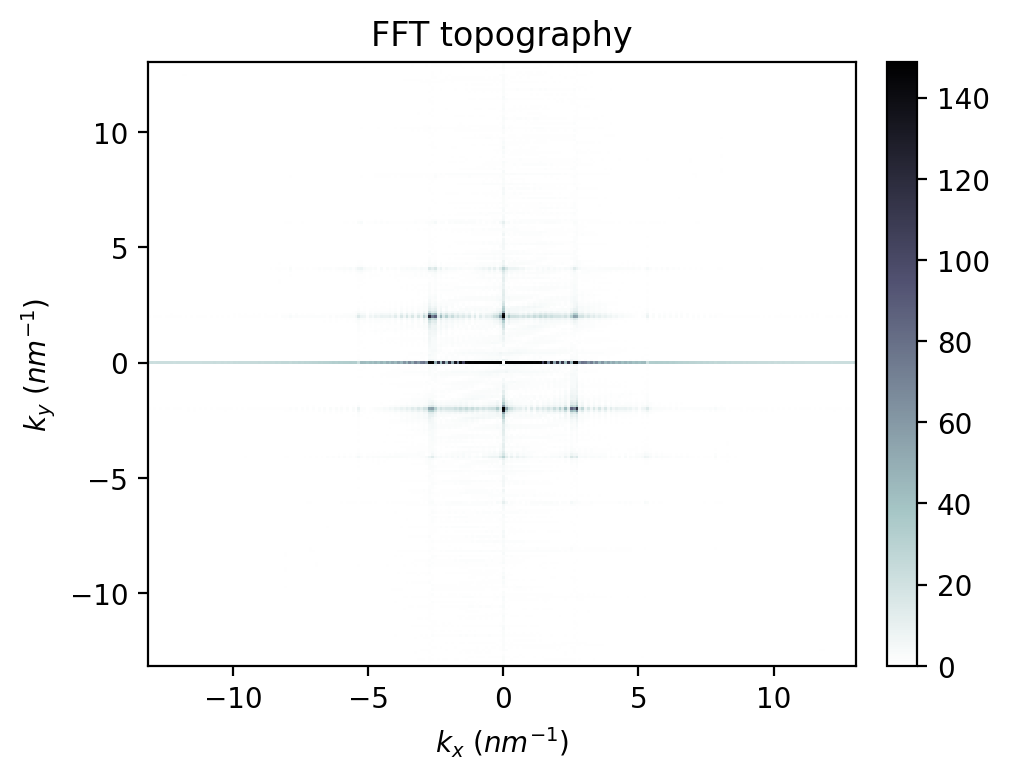

In [10]:
# Save FFT data as EPS
plt.figure(figsize=(5,4), dpi=200)
plt.xlabel('$k_x\ (nm^{-1}$)')
plt.ylabel('$k_y\ (nm^{-1}$)')
plt.title('FFT topography')
im = plt.pcolormesh(x_fft, y_fft, np.abs(data_shift), cmap='bone_r', vmin=float(min_text_field.v_model), vmax=float(max_text_field.v_model))
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.savefig(f'z-topo-fft/z-fft_{filename}.eps', format='eps', facecolor='w', dpi=600)

header = f'File format = ASCII\nx-pixels = {data_shift.shape[1]}\ny-pixels = {data_shift.shape[0]}\nx-length = {x_fft.max()*2}\ny-length = {y_fft.max()*2}\nz-unit = nm\nStart of data:'

np.savetxt(f'z-topo-fft/z-fft_{filename}.asc', np.abs(data_shift), delimiter='\t', header=header, fmt='%.6f')